In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, WeightedRandomSampler, BatchSampler
import torch.nn.functional as F
from torchinfo import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
import random
import os

In [2]:
# -----------------------
# DEFINICIÓN DE LA RED
# -----------------------
class TwoBranchNet(nn.Module):
    def __init__(self, n_feat_muon=1000, n_feat_frec=2500, n_classes=21):
        super(TwoBranchNet, self).__init__()
        
        # --- Rama CNN Muones ---
        self.cnn_branch = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=15, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),         
            nn.MaxPool1d(2),
            

            nn.Conv1d(128, 256, kernel_size=5, padding='same'),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool1d(32),  # (batch, 256, 32)
            nn.Flatten()
        )
        
        # Rama 2: Respuesta en frecuencia simulada (MLP)
        self.mlp_branch = nn.Sequential(
            nn.Linear(n_feat_frec, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1)
        )

        # --- Cabezal de fusión ---
        self.head = nn.Sequential(
            nn.Linear(256*32 + 32, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )
        
    def forward(self, x_muon, x_freq):
        v1 = self.cnn_branch(x_muon)
        v1 = v1.view(v1.size(0), -1)
        v2 = self.mlp_branch(x_freq)
        merged = torch.cat([v1, v2], dim=1)
        out = self.head(merged)
        return out

# -----------------------
# Inicializar modelo
# -----------------------
model = TwoBranchNet(n_feat_muon=pulse_samples, n_feat_frec=n_feat_frec, n_classes=n_classes).to(device)
summary(model, input_size=[(1,1,1000), (1,2500)])

In [3]:
# -----------------------
# CONFIG
# -----------------------
pulse_samples = 1000     # n_feat_muon
n_feat_frec = 2500       # n_feat_frec
batch_size = 512
epochs = 120
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 21

print("Device:", device)

# Definir la arquitectura de la red (debe ser la misma que la entrenada)
model = TwoBranchNet(n_feat_muon=pulse_samples, n_feat_frec=n_feat_frec, n_classes=n_classes)

# Cargar los pesos guardados en 'model_weights/two_branch_net_v6bis.pth'
model.load_state_dict(torch.load("model_weights/two_branch_net_v5bis_v2.pth"))

# Mover el modelo al dispositivo (GPU o CPU)
model.to(device)

# Poner el modelo en modo de evaluación
model.eval()

Device: cuda


TwoBranchNet(
  (cnn_branch): Sequential(
    (0): Conv1d(1, 64, kernel_size=(15,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=same)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_branch): Sequential(
    (0): Linear(in_features=2500, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(

In [4]:
# Cargar los nuevos datos de muones
new_muon_dataset_path = r"C:\Users\Usuario\Documents\Sistema Dinamicos - Archivos Grandes\muon_dataset_onlyX.npz"
data_new = np.load(new_muon_dataset_path)
X_muones_new = data_new['X']

# Normalizar los pulsos de muones
max_global = X_muones_new.max()
X_muones_new = X_muones_new / (max_global + 1e-8)

# Convertir a tensores
X_muones_new = torch.tensor(X_muones_new, dtype=torch.float32).unsqueeze(1)

# Cargar y preparar los datos de frecuencia
simulated_npz_path = "Espectros/spectrum_real.npz"

def load_npz(path):
    data = np.load(path)
    freq = data['freq']
    att = data['attenuation_db']
    return torch.tensor(freq, dtype=torch.float32), torch.tensor(att, dtype=torch.float32)

sim_freq, H_sim = load_npz(simulated_npz_path)
H_sim_norm_new = (H_sim - H_sim.min()) / (H_sim.max() - H_sim.min() + 1e-8)
H_sim_batch_new = H_sim_norm_new.repeat(X_muones_new.shape[0], 1)

# Crear un DataLoader para manejar los datos en lotes
# ¡Aquí está el cambio! Solo se pasan los datos de entrada
new_dataset = TensorDataset(X_muones_new, H_sim_batch_new)
new_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)

# -----------------------
# INFERENCIA
# -----------------------
all_preds = []
all_probs = []

with torch.no_grad():
    for x_muon_batch, x_freq_batch in new_loader:
        x_muon_batch = x_muon_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        
        output = model(x_muon_batch, x_freq_batch)
        preds = output.argmax(dim=1)
        probs = nn.functional.softmax(output, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Ahora puedes analizar la distribución de las predicciones
unique_preds, pred_counts = np.unique(all_preds, return_counts=True)
print("Distribución de las predicciones del modelo:")
for pred, count in zip(unique_preds, pred_counts):
    print(f"Clase {pred}: {count} muestras")

Distribución de las predicciones del modelo:
Clase 0: 367 muestras
Clase 1: 93 muestras
Clase 2: 255 muestras
Clase 3: 462 muestras
Clase 4: 1724 muestras
Clase 5: 21462 muestras
Clase 6: 43769 muestras
Clase 7: 31705 muestras
Clase 8: 163 muestras


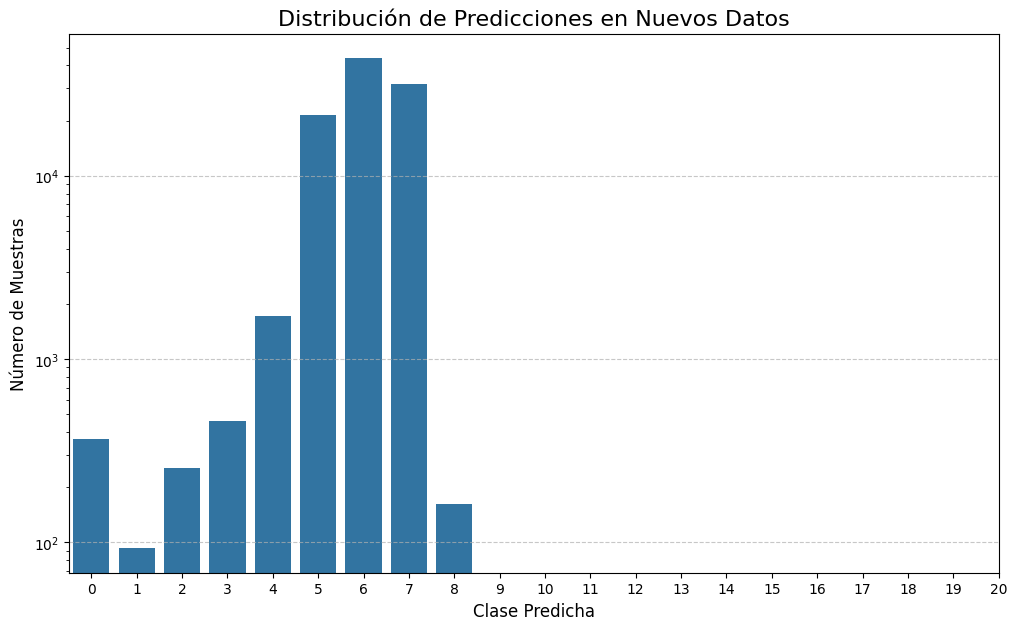

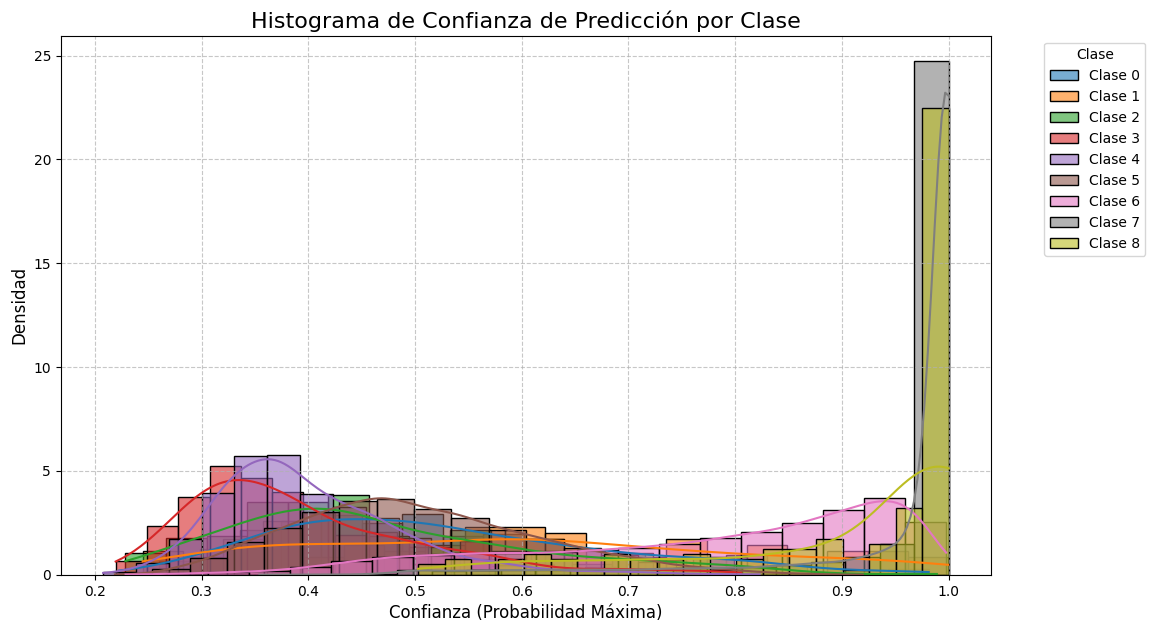


Análisis de predicciones completado. Revise los gráficos generados.


In [5]:
# -----------------------
# ANÁLISIS Y VISUALIZACIÓN
# -----------------------

# Plot 1: Bar chart of prediction distribution
plt.figure(figsize=(12, 7))
sns.countplot(x=all_preds)
plt.title("Distribución de Predicciones en Nuevos Datos", fontsize=16)
plt.yscale('log')
plt.xlabel("Clase Predicha", fontsize=12)
plt.ylabel("Número de Muestras", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=range(n_classes), labels=range(n_classes))
plt.show()

# Plot 2: Histogram of prediction confidence for each class
plt.figure(figsize=(12, 7))
for class_id in np.unique(all_preds):
    class_indices = np.where(all_preds == class_id)[0]
    if len(class_indices) > 0:
        confidences = all_probs[class_indices, class_id]
        sns.histplot(confidences, kde=True, label=f'Clase {class_id}', bins=20, stat='density', alpha=0.6)
plt.title("Histograma de Confianza de Predicción por Clase", fontsize=16)
#plt.yscale('log')
plt.xlabel("Confianza (Probabilidad Máxima)", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.legend(title="Clase", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\nAnálisis de predicciones completado. Revise los gráficos generados.")